# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [71]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [257]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [258]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import torchvision

In [259]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    rootdir = 'processed_celeba_small'
    loader_transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    image_folder = torchvision.datasets.ImageFolder(data_dir, transform = loader_transform)
    data_loader = torch.utils.data.DataLoader(image_folder,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
    return data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [260]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

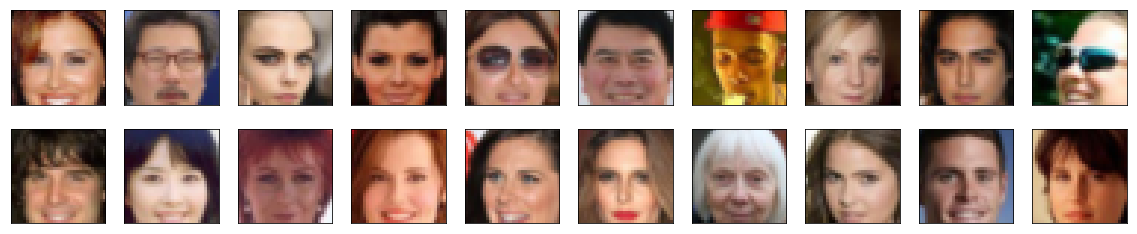

In [261]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [262]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max=feature_range
    distance=x*(max-min)+min
    
    return distance

In [263]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9373)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [264]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [265]:
def Conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, bias = False):
    '''Helper function used to create convolutional layers with subsequent batch norm'''
    layers = []
    conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride = stride, padding = padding, bias = bias)
    layers.append(conv)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    #now return sequential of layers
    return nn.Sequential(*layers)

In [266]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        #DCGAN paper indicates that the best leaky relu constant is .2
        self.leaky_relu_constant = 0.2
        #stride and padding for our convolutional layers
        self.stride = 2
        self.padding = 1
        self.conv_bias = False
        self.dropout_constant = 0.25
        
        #three convolutional layers, similar to DCGAN solution
        self.conv1 = Conv(3, conv_dim, 3, stride = self.stride, padding = self.padding, batch_norm = False, bias = self.conv_bias)
        
        self.conv2 = Conv(conv_dim, conv_dim * 2, 3, stride = self.stride, padding = self.padding, batch_norm = True, bias = self.conv_bias)
        
        self.conv3 = Conv(conv_dim * 2, conv_dim*4, 3, stride = self.stride, padding = self.padding, batch_norm = True, bias = self.conv_bias)
        
        #dropout and 
        #fully connected layer
        self.dropout = nn.Dropout(self.dropout_constant)

        self.fc1 = nn.Linear(conv_dim * 4 * 4 * 4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        #relu constant
        relu = self.leaky_relu_constant
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), relu)
        #batch norm 2 and conv2 
        x = F.leaky_relu(self.conv2(x), relu)
        #batch norm 3 and conv3
        x = F.leaky_relu(self.conv3(x), relu)
        #now flatten output
        
        #now run output through fully connected layer
        x = x.view(-1, self.conv_dim * 4 * 4 * 4)
        
        x = self.dropout(x)
        x = self.fc1(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [267]:
def Deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, bias = False):
    '''Helper function used to create transpose convolutional layer, with optional batch normalization'''
    
    layers = []
    transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride = stride, padding = padding, bias = bias)
    layers.append(transpose_conv)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [268]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        #stride and padding for our convolutional layers
        self.stride = 2
        self.padding = 2
        #leaky relu constant
        self.leaky_relu_constant = 0.2
        self.conv_bias = False
        self.batch_norm = True
        self.linear_output_dim = conv_dim * 4 * 4 * 8
        self.dropout_constant = 0.25
        
        #fc1
        self.fc1 = nn.Linear(z_size, conv_dim * 4 * 4 * 8)
        #adding dropout
        self.dropout = nn.Dropout(self.dropout_constant)
        
        #now transpose convolutional layers
        self.transpose_conv1 = Deconv(self.conv_dim * 8, self.conv_dim * 4, 5, stride = self.stride, padding = self.padding + 1, batch_norm = self.batch_norm, bias = self.conv_bias)
        
        self.transpose_conv2 = Deconv(self.conv_dim * 4, self.conv_dim * 2, 5, stride = self.stride, padding = self.padding, batch_norm = self.batch_norm, bias = self.conv_bias)
        
        self.transpose_conv3 = Deconv(self.conv_dim * 2, self.conv_dim, 5, stride = self.stride, padding = self.padding, batch_norm = self.batch_norm, bias = self.conv_bias)
        
        self.transpose_conv4 = Deconv(self.conv_dim, 3, 4, stride = self.stride, padding = self.padding ,batch_norm = False, bias=self.conv_bias)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        relu = self.leaky_relu_constant
        # define feedforward behavior
        x = self.fc1(x)
        #x = self.dropout(x)
        x = x.view(-1, self.conv_dim * 8, 4, 4)
        
        #transpose convolutional layers
        x = self.transpose_conv1(x)
        x = F.relu(x)
        x = self.transpose_conv2(x)
        x = F.relu(x)
        x = self.transpose_conv3(x)
        x = F.relu(x)
        x = self.transpose_conv4(x)
        x = torch.tanh(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [269]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    std_dev = 0.02
    mean = 0
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean, std_dev)
    
        #if we have bias terms, zero these out
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [270]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [271]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.25)
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=16384, bias=True)
  (dropout): Dropout(p=0.25)
  (transpose_conv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (transpose_conv2): Sequential(
   

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [272]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [273]:
smooth_parameter = 0.10
#use mean squared error loss
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    #label smoothing
    labels = torch.ones(batch_size) * (1 - smooth_parameter)
    #move labels to gpu if available
    if train_on_gpu:
        labels = labels.cuda()
    #choose least squares error as criterion
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    #move labels to gpu if available
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [274]:
#Hyperparameters taken from DCGAN paper suggestions
import torch.optim as optim
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9999

d_adam = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
g_adam = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])
# Create optimizers for the discriminator D and generator G
d_optimizer =  d_adam #d_sgd
g_optimizer =  g_adam #g_sgd

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [275]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    G_Temp = G
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_loss_value = 100
            #discriminator batch hyperparameter, how many times to train discriminator to generator
            discriminator_batch = 1
            for i in range(discriminator_batch):
                    
                #zero gradient
                d_optimizer.zero_grad()
                #real images
                if train_on_gpu:
                    real_images = real_images.cuda()
                D_real = D(real_images)
                d_real_loss = real_loss(D_real)
                #fake images
                z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)
                D_fake = D(fake_images)
                d_fake_loss = fake_loss(D_fake)
                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                d_optimizer.step()
            
                #number of times we attempt to generate and retrain the generator
                #there were sources that indicated this would help with divergent discrim / generator issues
                generator_batch = 1
                batch_multiplier = 1
                range_modifier = 1
                d_loss_value = d_loss.item()
            
            # 2. Train the generator with an adversarial loss
            #zero gradient
            for i in range(generator_batch):
                g_optimizer.zero_grad()
            
                #Generate fake images
                z = np.random.uniform(-1, 1, size=(batch_size * batch_multiplier, z_size))
                z = torch.from_numpy(z).float()
                if train_on_gpu:
                    z = z.cuda()
                fake_images = G(z)
            
                #get discriminator losses on fakes
                D_fake = D(fake_images)
                g_loss = real_loss(D_fake)
                g_loss.backward()
                g_optimizer.step()
                
                for p in list(filter(lambda p: p.grad is not None, G.parameters())):
                    if p.grad.data.norm(2).item() > 100:
                        'Watch out. Exploding gradient!'
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    print('Finished Training')
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [276]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.6368 | g_loss: 1.2840
Epoch [    1/   30] | d_loss: 0.4620 | g_loss: 5.1000
Epoch [    1/   30] | d_loss: 1.0080 | g_loss: 1.6921
Epoch [    1/   30] | d_loss: 0.9430 | g_loss: 1.8746
Epoch [    1/   30] | d_loss: 1.0002 | g_loss: 2.3871
Epoch [    1/   30] | d_loss: 1.0136 | g_loss: 1.7705
Epoch [    1/   30] | d_loss: 0.9263 | g_loss: 2.1575
Epoch [    1/   30] | d_loss: 0.9105 | g_loss: 2.5421
Epoch [    1/   30] | d_loss: 1.2391 | g_loss: 2.9094
Epoch [    1/   30] | d_loss: 1.2248 | g_loss: 1.5297
Epoch [    1/   30] | d_loss: 1.0017 | g_loss: 1.8616
Epoch [    1/   30] | d_loss: 1.2036 | g_loss: 2.1386
Epoch [    1/   30] | d_loss: 1.1533 | g_loss: 1.3372
Epoch [    1/   30] | d_loss: 1.1608 | g_loss: 1.6252
Epoch [    1/   30] | d_loss: 1.2374 | g_loss: 1.3001
Epoch [    1/   30] | d_loss: 1.2078 | g_loss: 1.5827
Epoch [    2/   30] | d_loss: 1.3038 | g_loss: 2.2408
Epoch [    2/   30] | d_loss: 1.3280 | g_loss: 1.0763
Epoch [    2/   30] | d_loss

Epoch [   10/   30] | d_loss: 1.2421 | g_loss: 1.2871
Epoch [   10/   30] | d_loss: 1.2150 | g_loss: 1.1521
Epoch [   10/   30] | d_loss: 1.2895 | g_loss: 1.2562
Epoch [   10/   30] | d_loss: 1.2350 | g_loss: 1.1916
Epoch [   10/   30] | d_loss: 1.3411 | g_loss: 1.3393
Epoch [   10/   30] | d_loss: 1.0939 | g_loss: 1.5230
Epoch [   10/   30] | d_loss: 1.1334 | g_loss: 1.4264
Epoch [   10/   30] | d_loss: 1.4333 | g_loss: 0.8795
Epoch [   10/   30] | d_loss: 1.1400 | g_loss: 1.1636
Epoch [   11/   30] | d_loss: 1.3268 | g_loss: 0.9837
Epoch [   11/   30] | d_loss: 1.2280 | g_loss: 1.0900
Epoch [   11/   30] | d_loss: 1.2659 | g_loss: 1.0382
Epoch [   11/   30] | d_loss: 1.1328 | g_loss: 1.1360
Epoch [   11/   30] | d_loss: 1.3027 | g_loss: 0.9728
Epoch [   11/   30] | d_loss: 1.4016 | g_loss: 1.0162
Epoch [   11/   30] | d_loss: 1.2026 | g_loss: 1.2617
Epoch [   11/   30] | d_loss: 1.2589 | g_loss: 1.1533
Epoch [   11/   30] | d_loss: 1.2612 | g_loss: 1.0906
Epoch [   11/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.9671 | g_loss: 1.7785
Epoch [   19/   30] | d_loss: 1.1603 | g_loss: 1.1136
Epoch [   20/   30] | d_loss: 1.2339 | g_loss: 0.8828
Epoch [   20/   30] | d_loss: 1.0589 | g_loss: 1.1378
Epoch [   20/   30] | d_loss: 1.1813 | g_loss: 1.5051
Epoch [   20/   30] | d_loss: 1.2243 | g_loss: 1.0744
Epoch [   20/   30] | d_loss: 1.0100 | g_loss: 1.5091
Epoch [   20/   30] | d_loss: 1.2547 | g_loss: 1.0576
Epoch [   20/   30] | d_loss: 1.3169 | g_loss: 1.1528
Epoch [   20/   30] | d_loss: 1.0626 | g_loss: 1.7440
Epoch [   20/   30] | d_loss: 1.1429 | g_loss: 1.4029
Epoch [   20/   30] | d_loss: 1.1193 | g_loss: 1.9987
Epoch [   20/   30] | d_loss: 1.1399 | g_loss: 1.8927
Epoch [   20/   30] | d_loss: 1.0723 | g_loss: 1.5201
Epoch [   20/   30] | d_loss: 1.0148 | g_loss: 1.1351
Epoch [   20/   30] | d_loss: 1.2256 | g_loss: 1.1342
Epoch [   20/   30] | d_loss: 1.1401 | g_loss: 1.2044
Epoch [   20/   30] | d_loss: 1.1017 | g_loss: 1.5902
Epoch [   21/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.9366 | g_loss: 1.6398
Epoch [   29/   30] | d_loss: 0.8492 | g_loss: 1.9486
Epoch [   29/   30] | d_loss: 0.9444 | g_loss: 1.4459
Epoch [   29/   30] | d_loss: 1.0459 | g_loss: 1.9692
Epoch [   29/   30] | d_loss: 0.9230 | g_loss: 1.4046
Epoch [   29/   30] | d_loss: 0.8212 | g_loss: 2.1139
Epoch [   29/   30] | d_loss: 0.9495 | g_loss: 2.4577
Epoch [   29/   30] | d_loss: 0.7922 | g_loss: 2.4672
Epoch [   29/   30] | d_loss: 0.9341 | g_loss: 1.5772
Epoch [   29/   30] | d_loss: 0.9805 | g_loss: 1.7105
Epoch [   29/   30] | d_loss: 1.1139 | g_loss: 1.8252
Epoch [   30/   30] | d_loss: 0.7451 | g_loss: 2.0200
Epoch [   30/   30] | d_loss: 1.1860 | g_loss: 0.8124
Epoch [   30/   30] | d_loss: 1.0803 | g_loss: 1.1552
Epoch [   30/   30] | d_loss: 0.9558 | g_loss: 1.8906
Epoch [   30/   30] | d_loss: 1.0513 | g_loss: 1.3758
Epoch [   30/   30] | d_loss: 0.9018 | g_loss: 2.2898
Epoch [   30/   30] | d_loss: 1.2709 | g_loss: 1.4284
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

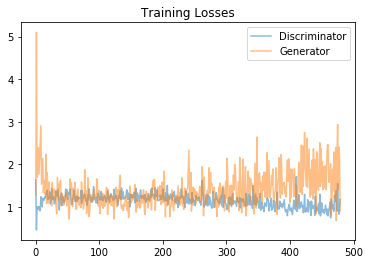

In [277]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [278]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [279]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

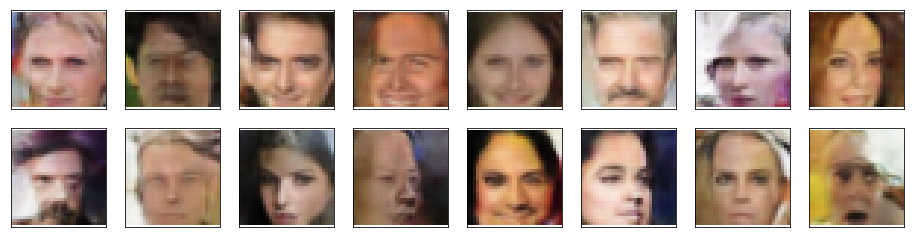

In [292]:
_ = view_samples(29, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** My samples are pretty close to a real human face. The one flaw I noticed is that some boundaries are rather fuzzy, and they sometimes contain incongruous elements, like half a mustache, mismatched eyes, elements of masculine and feminine. 

I finally got this to work after tuning my model more and fixing a bug in the dataloader with how I was handling images.

To achieve this, I tried to closely match hyperparameters, optimizers, etc from the original DCGAN paper and use them with my network.

I also tried some other suggestions I found on the web, namely by adding dropout to the generator, label smoothing, extra training of the generator, adding samples of old generators to the training loop periodically, even choosing a normal distribution for the noise used to seed the images...

I even tried a few different model architectures for the generator, instead of three t_conv layers with kernel size 4, using an odd sized kernel and using padding to get a 32x32 output. This seemed to be a bit better.

As for other things I'd try to improve this...

I'd try to add more data translation and noise into the data loaders.

I would try to get a larger dataset of faces at higher resolution.

I would train for a lot more epochs once I narrowed down an architecture that worked better. 

I might also try to see what the results are if I stop training earlier... It seemed like there was an interesting numeric effect where there may have been diminishing returns... We can see this in the increasing oscillations of the training curves.

I would add more code to see generated faces in process and maybe partially plot curves in progress, gradients, to get a really good sense of how the model is behaving numerically in the background...

Finally, I would try to address bias in my model by getting more faces from a broader source of individuals than just celebrities.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.